# Use Adam till convergence point then use SGDM

In [11]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
from PIL import Image

# import wandb

device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 256

cuda:0


## Import dataset

In [12]:
def load_data():
    img_shape = (32, 32)
    transform_train = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    transform_test = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    train_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
    test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_test)
    print('Number of training data:', len(train_data))
    print('Number of testing data:', len(test_data))

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, test_data, train_loader, test_loader
  
train_data, test_data, train_loader, test_loader = load_data()

Files already downloaded and verified
Files already downloaded and verified
Number of training data: 50000
Number of testing data: 10000


## Build model

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [14]:
def train(model, train_loader, optimizer, loss_func, epochs=30):
    accuracy_lst = []
    loss_lst = []
    model.train()
    for epoch in tqdm(range(epochs), desc=f"Training progress", colour="#00ff00"):
        total_loss = 0
        correct = 0
        num_labels = 0
        counter = 0
        start_time = time.time()
        for batch_idx, (X, y) in enumerate(tqdm(train_loader, leave=False, desc=f"Epoch {epoch + 1}/{epochs}", colour="#005500")):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = loss_func(output, y)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == y).sum()
            num_labels += len(y)
            counter += 1
        accuracy_lst.append((correct/num_labels).cpu().item())
        loss_lst.append(total_loss/counter)

        end_time = time.time()

        # wandb.log({'Accuracy': accuracy_lst[-1], 'Loss': loss_lst[-1]})

        print('Epoch %d, Loss %4f, Accuracy %4f, finished in %.4f seconds' % (epoch+1, total_loss/counter, correct/num_labels, end_time-start_time))
    
    return accuracy_lst, loss_lst

In [15]:
def evaluate(model, test_loader, loss_func):
    total_loss = 0
    correct = 0
    num_labels = 0
    counter = 0
    model.eval()
    for batch_idx, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)

        output = model(X)

        loss = loss_func(output, y)
        total_loss += loss.item()

        predicted = torch.max(output,1)[1]
        correct += (predicted == y).sum()
        num_labels += len(y)
        counter += 1
    print('Test Loss %4f, Test Accuracy %4f' % (total_loss/counter, correct/num_labels))

## Training

In [16]:
lr = 0.01

model = CNN().to(device)
print(model)

loss_func = nn.CrossEntropyLoss()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=4096, out_features=10, bias=True)
)


### Adam

In [17]:
# Adam
# Adam_run = wandb.init(project="CSI 5340 Project", entity="kwang126", name='Adam')
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=5e-4)

accuracy_lst_Adam, loss_lst_Adam = train(model, train_loader, optimizer, loss_func, 20)
evaluate(model, test_loader, loss_func)
# Adam_run.finish()

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Loss 3.197472, Accuracy 0.323160, finished in 14.1988 seconds


Epoch 2/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 1.471307, Accuracy 0.464960, finished in 14.2649 seconds


Epoch 3/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 1.272979, Accuracy 0.546160, finished in 14.1679 seconds


Epoch 4/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 1.151027, Accuracy 0.593360, finished in 14.3207 seconds


Epoch 5/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 1.071692, Accuracy 0.625380, finished in 15.1091 seconds


Epoch 6/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 1.017530, Accuracy 0.643040, finished in 14.8807 seconds


Epoch 7/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.976484, Accuracy 0.660940, finished in 14.0887 seconds


Epoch 8/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.959978, Accuracy 0.666460, finished in 14.1990 seconds


Epoch 9/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 0.944804, Accuracy 0.671980, finished in 14.7672 seconds


Epoch 10/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.929041, Accuracy 0.676260, finished in 14.5281 seconds


Epoch 11/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.921779, Accuracy 0.682640, finished in 14.6175 seconds


Epoch 12/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.911153, Accuracy 0.684560, finished in 14.4430 seconds


Epoch 13/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.912283, Accuracy 0.685260, finished in 14.4369 seconds


Epoch 14/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.910075, Accuracy 0.685640, finished in 14.4026 seconds


Epoch 15/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.904295, Accuracy 0.688300, finished in 14.4068 seconds


Epoch 16/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Loss 0.895845, Accuracy 0.690700, finished in 14.5095 seconds


Epoch 17/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Loss 0.898214, Accuracy 0.686380, finished in 14.3571 seconds


Epoch 18/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Loss 0.889578, Accuracy 0.692420, finished in 14.2303 seconds


Epoch 19/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Loss 0.898854, Accuracy 0.690520, finished in 14.3749 seconds


Epoch 20/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Loss 0.894903, Accuracy 0.691620, finished in 15.8069 seconds
Test Loss 1.202330, Test Accuracy 0.609000


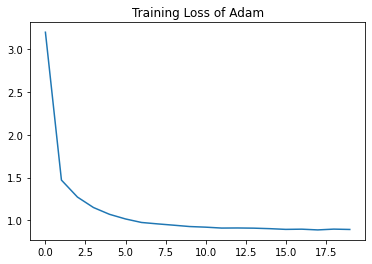

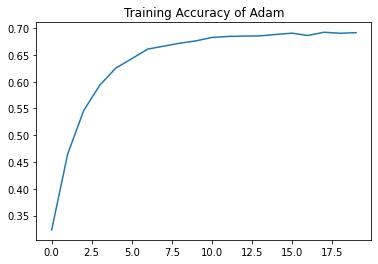

In [19]:
plt.plot(range(20), loss_lst_Adam)
plt.title('Training Loss of Adam')
plt.show()

plt.plot(range(20), accuracy_lst_Adam)
plt.title('Training Accuracy of Adam')
plt.show()

### SGDM

In [20]:
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.95, weight_decay=5e-4)

accuracy_lst_SGD, loss_lst_SGD = train(model, train_loader, optimizer, loss_func, 20)
evaluate(model, test_loader, loss_func)

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Loss 0.799625, Accuracy 0.723780, finished in 14.3403 seconds


Epoch 2/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 0.759264, Accuracy 0.740980, finished in 14.1648 seconds


Epoch 3/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 0.741285, Accuracy 0.743820, finished in 14.1429 seconds


Epoch 4/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 0.732708, Accuracy 0.749780, finished in 14.0120 seconds


Epoch 5/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 0.716141, Accuracy 0.753440, finished in 14.1146 seconds


Epoch 6/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 0.708845, Accuracy 0.758000, finished in 14.3931 seconds


Epoch 7/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.690428, Accuracy 0.763700, finished in 14.1826 seconds


Epoch 8/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.689179, Accuracy 0.762700, finished in 14.1153 seconds


Epoch 9/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 0.687010, Accuracy 0.763760, finished in 14.2886 seconds


Epoch 10/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.685644, Accuracy 0.762940, finished in 14.2300 seconds


Epoch 11/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.678203, Accuracy 0.765700, finished in 14.1452 seconds


Epoch 12/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.680018, Accuracy 0.767080, finished in 14.3126 seconds


Epoch 13/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.676962, Accuracy 0.767760, finished in 15.7633 seconds


Epoch 14/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.666337, Accuracy 0.771480, finished in 14.4335 seconds


Epoch 15/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.660007, Accuracy 0.774440, finished in 14.2044 seconds


Epoch 16/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Loss 0.662229, Accuracy 0.771160, finished in 14.2513 seconds


Epoch 17/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Loss 0.658131, Accuracy 0.773140, finished in 14.2506 seconds


Epoch 18/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Loss 0.656567, Accuracy 0.773760, finished in 14.2888 seconds


Epoch 19/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Loss 0.651395, Accuracy 0.774860, finished in 14.1943 seconds


Epoch 20/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Loss 0.651380, Accuracy 0.775320, finished in 14.2444 seconds
Test Loss 0.668735, Test Accuracy 0.773100


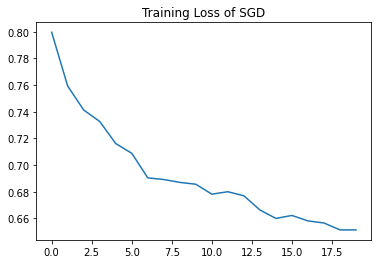

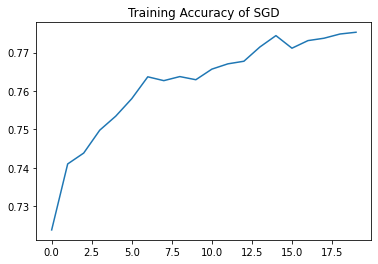

In [21]:
plt.plot(range(20), loss_lst_SGD)
plt.title('Training Loss of SGD')
plt.show()

plt.plot(range(20), accuracy_lst_SGD)
plt.title('Training Accuracy of SGD')
plt.show()